## Часть 1
Напишите скрипт, который скачивает все данные с выборов губернатора СПб 2019г для всех избирательных участков. 

Входная точка [по ссылке](http://notelections.online/region/region/st-petersburg?action=show&root=1&tvd=27820001217417&vrn=27820001217413&region=78&global=&sub_region=78&prver=0&pronetvd=null&vibid=27820001217417&type=222). Затем нужно перейти на сайты территориальных избирательных комиссий. Результаты нужно сохранить в  `cvs`-файл, `sqlite` базе данных или `parquet`-файле. В итоге должна получиться таблица с полями:
- название ТИК (территориальная избирательная комиссия, некоторое объединение избирательных участков на определенной территории)
- номер УИК (избирательный участок)
- 14 стандартных полей из итогового протокола

Скрипт должен быть в отдельном `*.py` файле или в отдельном `jupyter`-ноутбуке. 

In [1]:
import lxml.html
import lxml.etree
import requests
import pandas as pd
import numpy as np
url = 'http://notelections.online/region/region/st-petersburg?action=show&root=1&tvd=27820001217417&vrn=27820001217413&region=78&global=&sub_region=78&prver=0&pronetvd=null&vibid=27820001217417&type=222'

In [2]:
response = requests.get(url)
tree = lxml.html.fromstring(response.text)
BASE = tree.xpath('//head/base/@href')[0][:-1]
links = [BASE + link for link in tree.xpath('////table//table//a/@href')][:-1]
tiks = [str(i.text) for i in tree.xpath('////table//table//a')][:-1]

In [3]:
rows_2 = []
rows_1 = []
for tik, link in zip(tiks, links):
    response = requests.get(link)
    tree = lxml.html.fromstring(response.text)
    new_rows = [str(uik.text) for uik in tree.xpath('//table//table//a')]
    rows_2.extend(new_rows)
    m = len(new_rows)
    rows_1.extend([tik] * m)
    if link == links[0]:
        columns = [str(i.text) for i in tree.xpath('//table//table/tr/td/table//tr/td/nobr') if i.text]
        columns = [columns[i] for i in range(len(columns)) if i % 2 == 1]
        data = np.array([int(i.text) for i in tree.xpath('//table//table//td/div/table//tr/td/nobr/b')]).reshape(-1, m).T
    else:
        data = np.vstack((data, np.array([int(i.text) for i in tree.xpath('//table//table//td/div/table//tr/td/nobr/b')]).reshape(-1, m).T))

In [5]:
rows = pd.MultiIndex.from_tuples(list(zip(rows_1, rows_2)))
df = pd.DataFrame(data, columns=columns, index=rows)
df.to_csv('election.csv', sep=',', encoding='utf-8-sig')

### Часть 2
Используя скаченные данные и `Pandas` (или `PySpark`) посчитайте:
- явку (%) по всем ТИК, результат отсортировать по убыванию
- выберите произвольного кандидата и найдите тот избиратльный участок, на котором он получил наибольший результат  (%, учитывать участки на которых проголосовало больше 100 человек)
- найдите ТИК, где разница между УИК с наибольшей явкой и наименьшей максимальна
- посчитайте дисперсию по явке для каждого ТИК (учитывать УИК)
- для каждого кандидата посчитайте таблицу: результат (%, округленный до целого) - количество УИК, на которых кандидат получил данный результат
- визуализируйте отношение - явка на УИК $\rightarrow$ результат кандидата. 

In [8]:
df = pd.read_csv("election.csv", index_col=[0,1])
df.head()

Число избирателей, внесенных в список избирателей на момент окончания голосования  \
Территориальная избирательная комиссия №1 УИК №1                                               1803                                   
                                          УИК №2                                               1466                                   
                                          УИК №3                                               2092                                   
                                          УИК №4                                               1056                                   
                                          УИК №5                                               1827                                   

                                                  Число избирательных бюллетеней, полученных участковой избирательной комиссией  \
Территориальная избирательная комиссия №1 УИК №1                                               1200                               
                                          УИК №2                                               1100                               
                                          УИК №3                                               1600                               
                                          УИК №4                                               1000                               
                                          УИК №5                                               1400                               

                                                  Число избирательных бюллетеней, выданных избирателям в помещении для голосования в день голосования  \
Территориальная избирательная комиссия №1 УИК №1                                                587                                                     
                                          УИК №2                                                433                                                     
                                          УИК №3                                                576                                                     
                                          УИК №4                                                318                                                     
                                          УИК №5                                                495                                                     

                                                  Число избирательных бюллетеней, выданных избирателям, проголосовавшим вне помещения для голосования  \
Территориальная избирательная комиссия №1 УИК №1                                                 11                                                     
                                          УИК №2                                                 14                                                     
                                          УИК №3                                                 22                                                     
                                          УИК №4                                                  4                                                     
                                          УИК №5                                                  8                                                     

                                                  Число погашенных избирательных бюллетеней  \
Территориальная избирательная комиссия №1 УИК №1                                        602   
                                          УИК №2                                        653   
                                          УИК №3                                       1002   
                                          УИК №4                                        678   
                                          УИК №5                                        897   

                                           

In [12]:
simplify = lambda x: int(x[x.find('№') + 1:])
new_index = pd.MultiIndex.from_tuples([(simplify(tik), simplify(uik)) for tik, uik in df.index], names=['tik', 'uik'])
new_columns = ['nvoter', 'nvoted', 'Amosov', 'Beglov', 'Tikhonova']
old_columns = df.columns[[0, 8, 11, 12, 13]]
data = pd.DataFrame(df[old_columns].values, columns = new_columns, index=new_index)
data['attendance'] = data['nvoted']/data['nvoter']*100

In [13]:
data['attendance'].groupby('tik').mean().sort_values(ascending=False)

tik
18    51.403167
15    49.268268
13    43.801869
30    40.884777
19    38.481687
2     37.620132
8     37.232256
23    36.790396
20    35.377543
22    35.055449
28    32.820550
1     32.407386
4     32.306425
9     32.163636
29    32.046683
21    31.917832
17    31.479702
24    31.203071
10    29.571517
7     28.628103
11    28.527966
16    28.244321
25    28.149335
26    27.757233
14    26.936866
5     26.899423
3     26.685753
12    26.129134
27    25.975296
6     24.379825
Name: attendance, dtype: float64

In [14]:
pr_beglov = data[data['nvoted']>100]['Beglov']/data[data['nvoted']>100]['nvoted']
max_idx = pr_beglov.idxmax()
max_value = pr_beglov.max()
print("ТИК №{}, УИК №{}, проголосовавших: {:.2f}%".format(*max_idx, max_value * 100))
data.loc[max_idx].astype(int)

ТИК №22, УИК №403, проголосовавших: 98.05%


nvoter        668
nvoted        665
Amosov          6
Beglov        652
Tikhonova       7
attendance     99
Name: (22, 403), dtype: int32

In [15]:
difference = data['attendance'].groupby('tik').max() - data['attendance'].groupby('tik').min()
print("Наибольшая разница на {} ТИКе: {:.2f}%".format(difference.idxmax(), difference.max()))

Наибольшая разница на 11 ТИКе: 80.75%


In [16]:
data['attendance'].groupby('tik').var()

tik
1     188.133458
2     456.180020
3      69.108981
4     221.862618
5     131.018165
6      18.510552
7      63.873858
8     222.281371
9     112.210987
10     74.900375
11    234.094658
12     31.018136
13    370.817654
14     29.995824
15    383.830541
16    102.581810
17    313.288501
18    238.953822
19    207.825797
20    164.346682
21    301.413929
22    416.765838
23    577.819994
24    263.010286
25      8.043611
26    192.770708
27    187.488823
28    369.688448
29    235.520634
30    500.703138
Name: attendance, dtype: float64

In [17]:
pr = (data[['Beglov', 'Amosov', 'Tikhonova']].div(data['nvoted'], axis=0)*100).astype(int)
percents = pd.DataFrame(index=list(range(0, 101)))
for cand in pr.columns:
    percents[cand] = pr[cand].value_counts()
percents = percents.fillna(0).astype(int)
percents

,Beglov,Amosov,Tikhonova
0,0,4,2
1,0,5,5
2,0,4,7
3,0,9,10
4,0,12,11
...,...,...,...
96,1,0,0
97,3,0,0
98,1,0,0
99,0,0,0


In [18]:
from matplotlib import pyplot as plt

pr['attendance'] = data['attendance']
pr = pr.sort_values(by='attendance')

#.plot.scatter(x='attendance', y=['Amosov','Beglov', 'Tikhonova']);

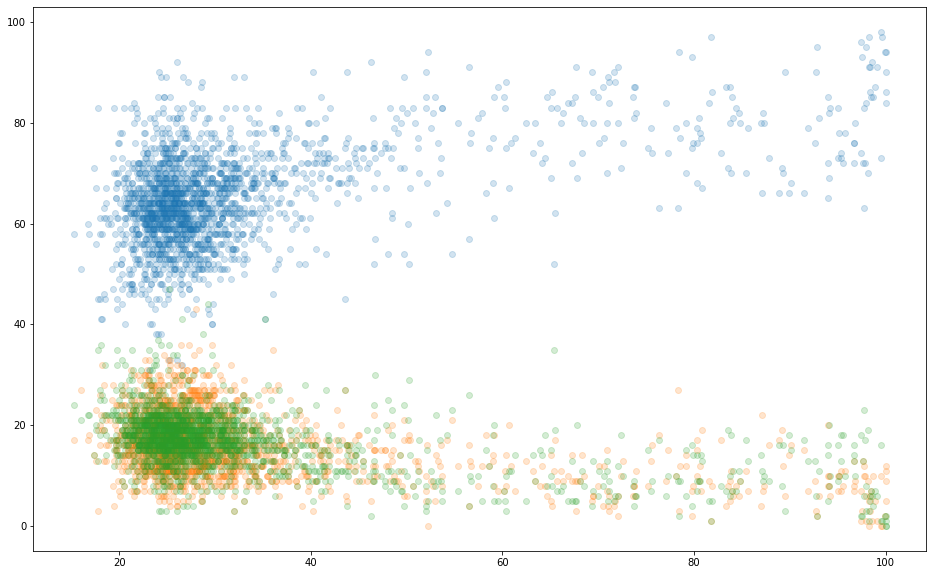

In [19]:
plt.figure(figsize=(16, 10))
plt.scatter(pr['attendance'], pr['Beglov'], alpha=0.2)
plt.scatter(pr['attendance'], pr['Amosov'], alpha=0.2)
plt.scatter(pr['attendance'], pr['Tikhonova'], alpha=0.2);